In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from os import sep
from skimage import io
from kornia.color import ycbcr_to_rgb

from network import DeepISP
from dataset import get_data
from loss import deepISPloss

from utils import *

/root/.pyenv/versions/proj/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cp_path = '/toleinik/projects/deepISP-implementation/CP'
data_path = '/toleinik/data/S7-ISP-new'
epoch = 300
norm_mode = 'simple'
train, test = get_data(data_path, target='m', batch_size=1, crop_size=None, flip=None, norm_mode=norm_mode)

print(f'train batch number {len(train)}')
print(f'test  batch number {len(test)}')

train batch number 693
test  batch number 297


In [3]:
cp = get_cp_name(epoch, cp_path)
params = cp.split(sep)[-1].split('_e')[0][5:].split('-')
model = DeepISP(*[int(i) for i in params], device='cpu')
cp = torch.load(cp)
o = cp['model_state_dict']
state_dict = {}
for i in o.keys():
    state_dict[i.replace('module.', '')] = o[i]
model.load_state_dict(state_dict)

criterion = deepISPloss(norm_mode=norm_mode)

In [4]:
n = 56
x, target = train.dataset[n]

img_shape = (x.shape[1], x.shape[2], x.shape[0])
x = x.reshape((1, *x.shape)).float()
target = target.reshape((1, *target.shape)).float()

with torch.no_grad():
    y = model(x)
    loss = criterion(y, target)
print('loss', loss)

norm = Norm(mode='positive')
y = norm(y, bounds_before=(-1, 1))
x = norm(x, bounds_before=(-1, 1))
target = norm(target, bounds_before=(-1, 1))

x = x[0].permute(1, 2, 0).cpu()
target = target[0].permute(1, 2, 0).cpu()
y = y[0].permute(1, 2, 0).cpu().detach().numpy()

loss tensor(0.0256)


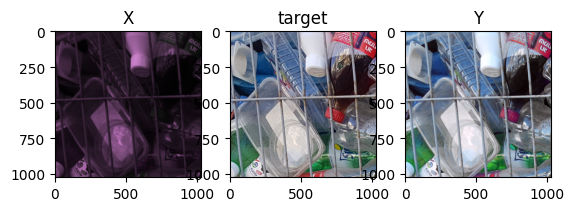

In [5]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x)
axs[0].set_title('X')
axs[1].imshow(target)
axs[1].set_title('target')
axs[2].imshow(y)
axs[2].set_title('Y')
plt.show()